# Cracks or No Cracks?

In [1]:
# 1. Setup 
import os
import shutil
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import layers,optimizers,losses,callbacks,applications

## Data Preparation 

In [2]:
# Path to data directory
data_dir = r"C:\Users\USER\Downloads\AI_SHRDC\Capstone2\Concrete Crack Images for Classification"

# List all image files in the directory
positive_files = [os.path.join(data_dir, 'positive', filename) for filename in os.listdir(os.path.join(data_dir, 'positive'))]
negative_files = [os.path.join(data_dir, 'negative', filename) for filename in os.listdir(os.path.join(data_dir, 'negative'))]

# Create labels based on folder names
positive_labels = [1] * len(positive_files)
negative_labels = [0] * len(negative_files)

# Split the positive and negative examples into training and testing sets
positive_train, positive_test, positive_train_labels, positive_test_labels = train_test_split(
    positive_files, positive_labels, test_size=0.2, random_state=42
)

negative_train, negative_test, negative_train_labels, negative_test_labels = train_test_split(
    negative_files, negative_labels, test_size=0.2, random_state=42
)

# Create directories for train and test
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories within train and test
train_positive_dir = os.path.join(train_dir, 'positive')
train_negative_dir = os.path.join(train_dir, 'negative')
test_positive_dir = os.path.join(test_dir, 'positive')
test_negative_dir = os.path.join(test_dir, 'negative')

os.makedirs(train_positive_dir, exist_ok=True)
os.makedirs(train_negative_dir, exist_ok=True)
os.makedirs(test_positive_dir, exist_ok=True)
os.makedirs(test_negative_dir, exist_ok=True)

# Move files to train directories
for src_file in positive_train:
    dest_file = os.path.join(train_positive_dir, os.path.basename(src_file))
    shutil.copy(src_file, dest_file)

for src_file in negative_train:
    dest_file = os.path.join(train_negative_dir, os.path.basename(src_file))
    shutil.copy(src_file, dest_file)

# Move files to test directories
for src_file in positive_test:
    dest_file = os.path.join(test_positive_dir, os.path.basename(src_file))
    shutil.copy(src_file, dest_file)

for src_file in negative_test:
    dest_file = os.path.join(test_negative_dir, os.path.basename(src_file))
    shutil.copy(src_file, dest_file)


In [3]:
# Create directories for train and test
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 32000 files belonging to 2 classes.
Found 8000 files belonging to 2 classes.


### Data Visualisation

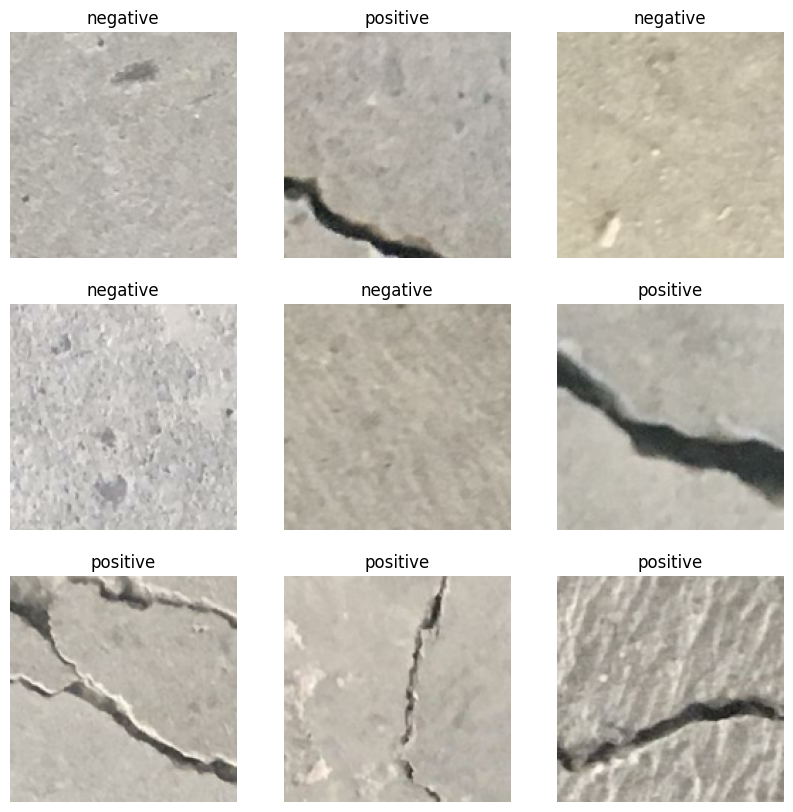

In [4]:
# Class name variables
class_names = train_dataset.class_names

# Plot pictures of data in 3x3 
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.grid('off')

### Data Spliting

In [5]:
# Split validation dataset into validation-test
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [6]:
# Convert tensorflow dataset into PreFetchDataset
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [7]:
# Create a sequential model for image augmentation
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal'))
data_augmentation.add(layers.RandomRotation(0.2))

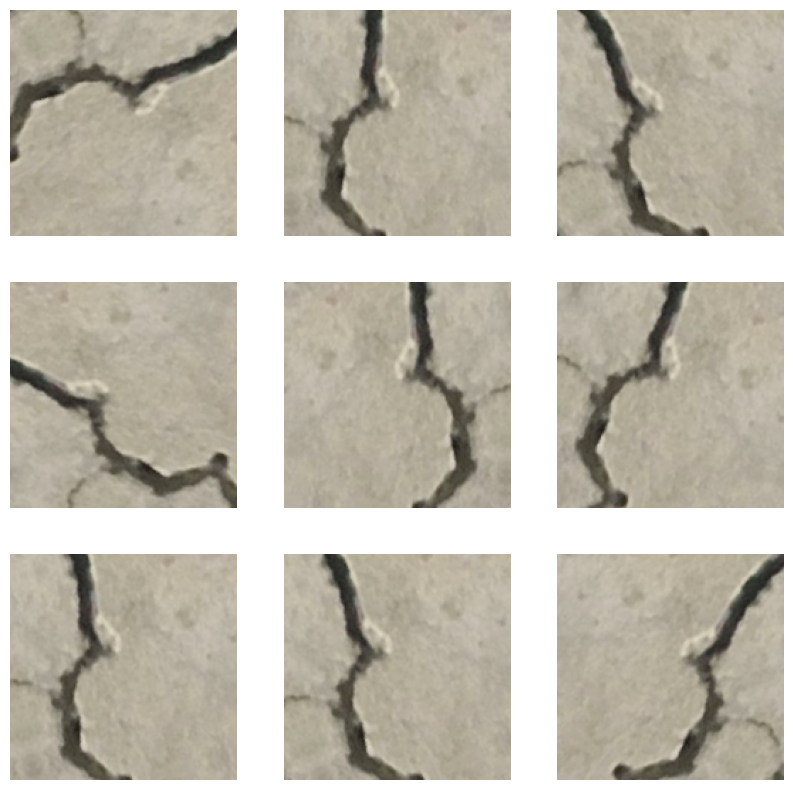

In [8]:
# Plot augmented data
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model Development

In [9]:
# Intialiase Mobilenetv2
preprocess_input = applications.mobilenet_v2.preprocess_input

In [10]:
# Load Pretrained Model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

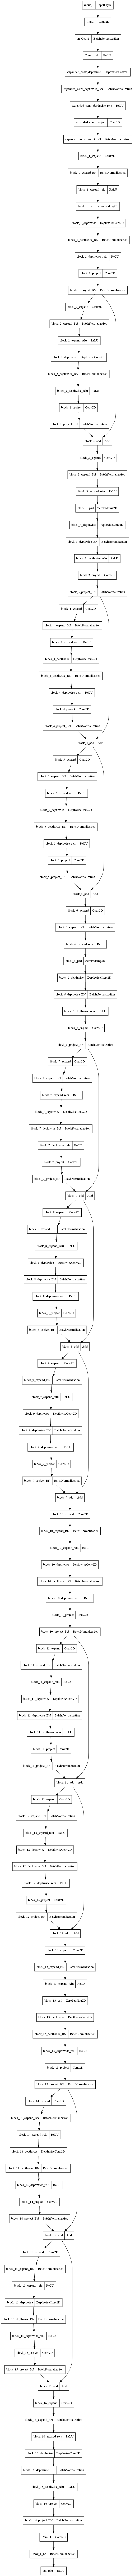

In [11]:
# Plot Model Stucture
keras.utils.plot_model(base_model)

In [12]:
# Freeze Feature Extractor
base_model.trainable = False 
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [13]:
# Create global average pooling layer
global_avg = layers.GlobalAveragePooling2D()

In [14]:
# Create output layer with Dense layer
output_layer = layers.Dense(len(class_names),activation = 'sigmoid')

In [15]:
# Build the entire pipeline using functional API
#  Input
inputs = keras.Input(shape=IMG_SHAPE)

#  Data augmentation 
x = data_augmentation(inputs)

#  Data Normalization 
x = preprocess_input(x)

#  Transfer learning feature extractor 
x = base_model(x,training=False)

#  Classification layers
x = global_avg(x)
x = layers.Dropout(0.3)(x)
outputs = output_layer(x)

#  Build Model
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Compile Model 

In [16]:
# Model Compile 
optimizers = optimizers.Adam(learning_rate = 0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizers,loss=loss, metrics=['accuracy'])

In [17]:
# Setting Callback Parameters
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = callbacks.EarlyStopping(patience=3)
PATH = os.getcwd()
logpath = os.path.join(PATH,'tensorboard_log',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = callbacks.TensorBoard(logpath)

checkpoint_filepath = 'checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,save_best_only=True,monitor='val_loss', mode='auto', verbose=1)

In [18]:
# Evaluate model before training
model.evaluate(test_dataset)

125/125 [==============================] - 10s 46ms/step - loss: 0.6463 - accuracy: 0.6120


[0.646282434463501, 0.6119999885559082]

### Model Training

In [19]:
# Model training
EPOCHS = 20
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,callbacks=[early_stopping,tb,model_checkpoint_callback]
    )

Epoch 1/20
1000/1000 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9790
Epoch 1: val_loss improved from inf to 0.01264, saving model to checkpoint.h5
1000/1000 [==============================] - 130s 126ms/step - loss: 0.0653 - accuracy: 0.9790 - val_loss: 0.0126 - val_accuracy: 0.9967
Epoch 2/20
1000/1000 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9962
Epoch 2: val_loss improved from 0.01264 to 0.00908, saving model to checkpoint.h5
1000/1000 [==============================] - 114s 114ms/step - loss: 0.0140 - accuracy: 0.9962 - val_loss: 0.0091 - val_accuracy: 0.9975
Epoch 3/20
1000/1000 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9969
Epoch 3: val_loss improved from 0.00908 to 0.00756, saving model to checkpoint.h5
1000/1000 [==============================] - 107s 107ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0076 - val_accuracy: 0.9975
Epoch 4/20
1000/1000 [==============================]

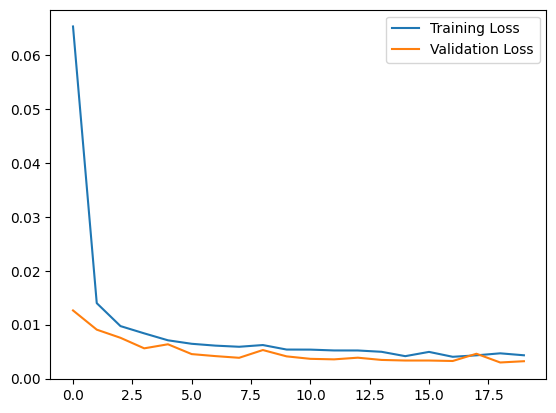

In [20]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [21]:
# Evaluation after training with best weight for output

model.load_weights(checkpoint_filepath)

model.evaluate(test_dataset)

125/125 [==============================] - 5s 36ms/step - loss: 0.0070 - accuracy: 0.9980


[0.006997860036790371, 0.9980000257492065]

### Model Deployment

In [22]:
# Model Deployment
# a. Retrieve a batch of the data test data and perform prediction

image_batch,label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [23]:
# Identify the class for the prediction
prediction_indexes = np.argmax(predictions, axis = 1)

In [24]:
# Display the result using matplotlib
label_map = {i:names for i , names in enumerate(class_names)}
prediction_list = [label_map[i] for i in prediction_indexes]
label_list = [label_map[i] for i in label_batch]

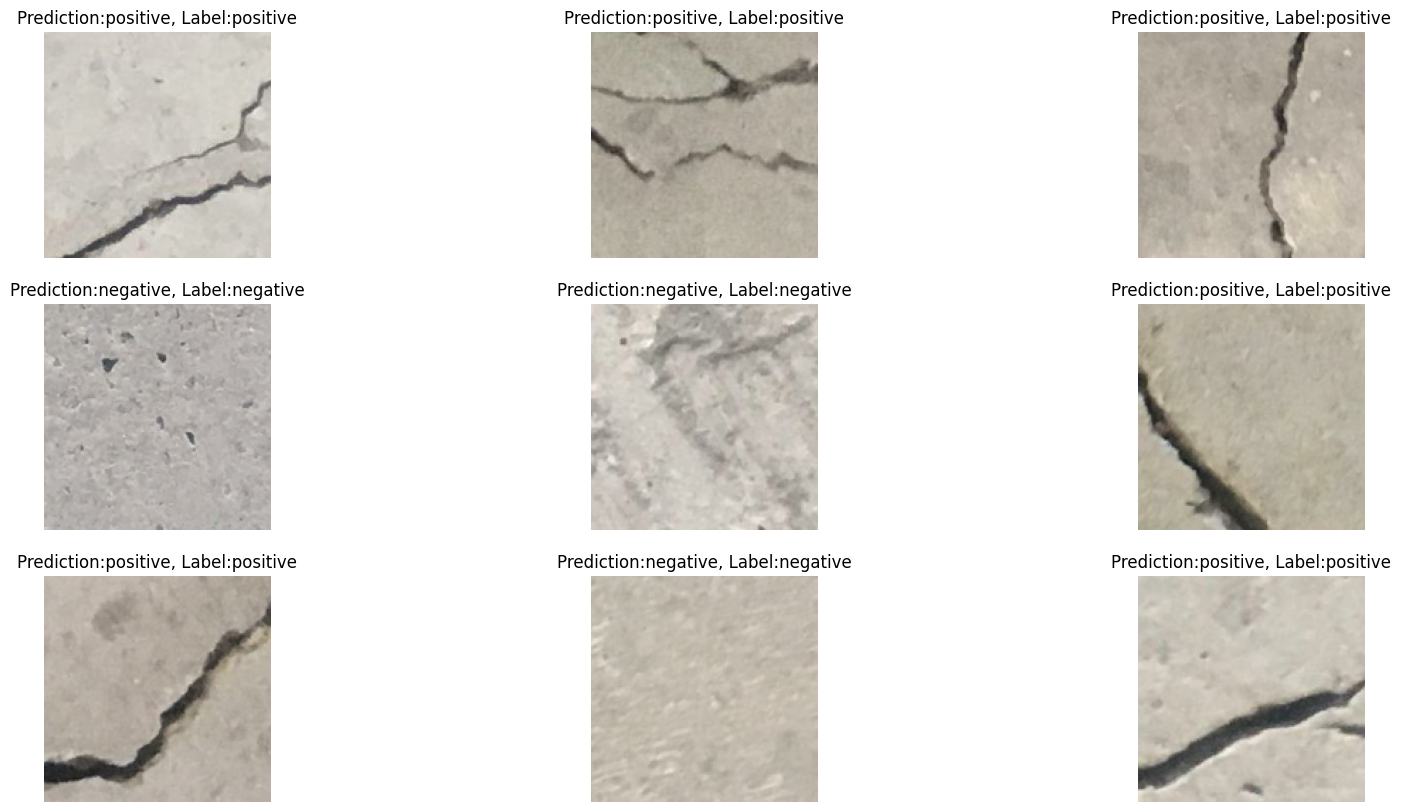

In [27]:
# Plot the prediction and actual
plt.figure(figsize = (20,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"Prediction:{prediction_list[i]}, Label:{label_list[i]}")
    plt.axis('off')
    plt.grid('off')